In [1]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#os.chdir("C:/Users/Nikita/Documents/GitHub/Self-learning-Monte-carlo-algorithms")
#os.chdir("C:/aut/Self-learning-Monte-carlo-algorithms")
import Ising
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

from sklearn.metrics import accuracy_score
from tqdm import tqdm_notebook as tqdm
from numba import jit
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from torch.utils.data import DataLoader, TensorDataset
%matplotlib inline
plt.style.use('ggplot')

In [2]:
!nvidia-smi

Sat Apr  4 15:11:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:1A:00.0 Off |                    0 |
| N/A   61C    P0   102W / 300W |   1536MiB / 32510MiB |     55%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:1C:00.0 Off |                    0 |
| N/A   32C    P0    42W / 300W |     11MiB / 32510MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
class Net(torch.nn.Module):
    def __init__(self, input_size=10*10, hidden_size=100):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.act = torch.nn.ReLU()
        #self.drop = torch.nn.Dropout(0.1)
        self.fc2 = torch.nn.Linear(hidden_size, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        #x = self.drop(x)
        x = self.fc2(x)
        return x

In [17]:
def find_point():
    global ind
    clouse = -1
    val1 = float("inf")
    output_val = net.forward(X_test.float())
    output_val_soft = cr(output_val).cpu().detach().numpy()
    
    y = []
    for i in range(X_test_time.shape[0]):
        mn = output_val_soft[:, 1][100*i:100*(i+1)].mean()
        y.append([X_test_time[i], mn])
    y.sort(key = lambda x: x[1])
    
    val = float("inf")
    for i in range(len(y)):
        mn = y[i][1]
        if abs(mn - 0.5) < abs(val - 0.5):
            clouse = i 
            val = mn
            
    print(val)
    print(y[clouse-1][0])
    print(y[clouse+1][0] if clouse+1 != len(y) else y[clouse][0])
    print(y[clouse][0])

# Loadind data and neural network training

In [5]:
def load(size, sample, n_obj):
    if sample == "train":
        X_path = "/home/nasorokin11/CPP/squre/size{}_min1_max3.5_step0.0625_batch1000_re100_N10000".format(str(size))
        y_path = "/home/nasorokin11/CPP/squre/labels_size{}_min1_max3.5_step0.0625_batch1000_re100_N10000".format(str(size))
    else:
        X_path = "/home/nasorokin11/CPP/size{}_min1_max3.5_step0.0625_batch1000_re100_N10000_triangular".format(str(size))
        y_path = "/home/nasorokin11/CPP/labels_size{}_min1_max3.5_step0.0625_batch1000_re100_N10000_triangular".format(str(size))
        
    with open(X_path) as fl:
            lines = fl.readlines()
    X_test = np.zeros((n_obj, size, size), dtype = np.int8)
    curr = 0
    for i in tqdm(range(len(lines))):
        if lines[i] == ';\n':
            curr += 1
        else:
            X_test[curr] = np.array(list(map(lambda x: int(x), lines[i][:-2].split(" "))))
        
    del lines
        
    with open(y_path) as fl:
        lines = fl.readlines()
    y_test = []
    for i in range(len(lines)):
        y_test.append(int(lines[i][0]))
    return X_test, y_test

In [6]:
def plot_fitting():
    net.eval()
    output_val = net.forward(X_test.to(device).float())
    output_val_soft = cr(output_val).cpu().detach().numpy()
    x_line = np.arange(0,1.2,0.2)
    output_0 = []
    for i in range(X_test_time.shape[0]):
        output_0.append(output_val_soft[:, 0][100*i:100*(i+1)].mean())
    plt.plot(X_test_time, output_0, '-.^g', alpha=0.5)
    output_1 = []
    for i in range(X_test_time.shape[0]):
        output_1.append(output_val_soft[:, 1][100*i:100*(i+1)].mean())
    plt.plot(X_test_time, output_1, '-.^b', alpha=0.5)
    plt.plot([3.65]*x_line.shape[0], x_line, '-')
    plt.show()

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# load
size = 256
x = np.arange(1, 3.5, 0.0625)
X_train, y_train = load(size, "train", 40000)
X_test, y_test = load(size, "test", 30100)
            
print("size:", size)
    
X_test_time = np.arange(1, 4, 0.01)
    
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], size*size)
X_test = torch.from_numpy(X_test).to(device)
y_test = np.array(y_test)
    
X_train = np.array(X_train)
X_train = X_train.reshape(X_train.shape[0], size*size)
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(np.array(y_train))
train_data = TensorDataset(X_train, y_train)
# dataloaders
train_data = TensorDataset(X_train, y_train)
batch_size = 16384

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

torch.cuda.empty_cache()
#train


In [15]:
net = Net(size*size)
net.to(device)
net.train()
    
cr = torch.nn.Softmax()
criterion = torch.nn.CrossEntropyLoss()
lr=3*(10**-4)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=0.01)
for e in tqdm(range(400)):
    net.train()    
    for X, y in train_loader:
        output = net.forward(X.to(device).float())
        y = y.to(device)
            
        loss = criterion(output, y.long())
        loss.backward()
        optimizer.step()
        net.zero_grad()

    if e % 10 == 0:
        net.eval()
        output = []
        output_val = []
        labels_train = []
        output_val = net.forward(X_test.float())
        for X, y in train_loader:
            output += net.forward(X.to(device).float()).tolist()
            labels_train += y.tolist()
            
        output_val = net.forward(X_test.float())

        print(e, ":", "val accuracy:", 
                    accuracy_score(np.around(cr((output_val))[:, 1].cpu().detach().numpy()), y_test),
                    "train accuracy:", accuracy_score(np.around(cr(torch.Tensor(output))[:, 1].detach().numpy()),labels_train))
    
net.eval()
plot_fitting()
find_point()
    
output_val = net.forward(X_test.to(device).float())
acc.append(accuracy_score(np.around(cr((output_val))[:, 1].cpu().detach().numpy()), y_test))
print("T", ind[-1])

/opt/software/python/anaconda/2019_10/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/software/python/anaconda/2019_10/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0 : val accuracy: 0.9086710963455149 train accuracy: 0.73575
10 : val accuracy: 0.9176744186046512 train accuracy: 0.952525
20 : val accuracy: 0.9246843853820598 train accuracy: 0.972375
30 : val accuracy: 0.9317275747508306 train accuracy: 0.9793
40 : val accuracy: 0.9354152823920265 train accuracy: 0.98315
50 : val accuracy: 0.9374750830564784 train accuracy: 0.985125
60 : val accuracy: 0.9386710963455149 train accuracy: 0.987175
70 : val accuracy: 0.9410963455149501 train accuracy: 0.989125
80 : val accuracy: 0.9413621262458471 train accuracy: 0.990625
90 : val accuracy: 0.9402657807308971 train accuracy: 0.992
100 : val accuracy: 0.9415282392026578 train accuracy: 0.99315
110 : val accuracy: 0.9423920265780731 train accuracy: 0.994275
120 : val accuracy: 0.9419933554817276 train accuracy: 0.9951
130 : val accuracy: 0.9424252491694353 train accuracy: 0.9962
140 : val accuracy: 0.9426578073089701 train accuracy: 0.996975
150 : val accuracy: 0.9428571428571428 train accuracy: 0.9973
1

KeyboardInterrupt: 

/opt/software/python/anaconda/2019_10/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


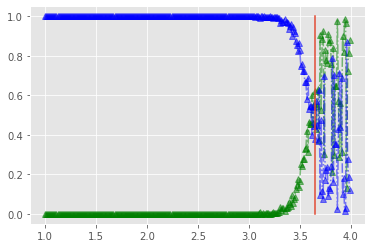

/opt/software/python/anaconda/2019_10/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


0.47374743
3.6700000000000026
3.5900000000000025
3.7100000000000026
0.9429900332225913


In [20]:
net.eval()
plot_fitting()
find_point()
    
output_val = net.forward(X_test.to(device).float())
print(accuracy_score(np.around(cr((output_val))[:, 1].cpu().detach().numpy()), y_test))


size: 16


/opt/software/python/anaconda/2019_10/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/software/python/anaconda/2019_10/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0 : val accuracy: 0.7907641196013289 train accuracy: 0.627375
10 : val accuracy: 0.8547840531561461 train accuracy: 0.682225
20 : val accuracy: 0.8366112956810631 train accuracy: 0.76655
30 : val accuracy: 0.8109302325581396 train accuracy: 0.801575
40 : val accuracy: 0.801827242524917 train accuracy: 0.807075
50 : val accuracy: 0.8037541528239203 train accuracy: 0.808425
60 : val accuracy: 0.8035880398671096 train accuracy: 0.8116
70 : val accuracy: 0.8013621262458471 train accuracy: 0.81335
80 : val accuracy: 0.7999335548172758 train accuracy: 0.814275
90 : val accuracy: 0.8002990033222591 train accuracy: 0.815475
100 : val accuracy: 0.7992691029900332 train accuracy: 0.81625
110 : val accuracy: 0.7978405315614618 train accuracy: 0.8165
120 : val accuracy: 0.7968106312292359 train accuracy: 0.817425
130 : val accuracy: 0.7957475083056479 train accuracy: 0.817975
140 : val accuracy: 0.795016611295681 train accuracy: 0.818425
150 : val accuracy: 0.7941860465116279 train accuracy: 0.818

/opt/software/python/anaconda/2019_10/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


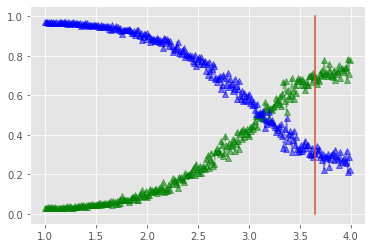

/opt/software/python/anaconda/2019_10/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
/opt/software/python/anaconda/2019_10/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.5019138
T 3.100000000000002



size: 32


0 : val accuracy: 0.8777740863787376 train accuracy: 0.58135
10 : val accuracy: 0.881827242524917 train accuracy: 0.7856
20 : val accuracy: 0.8542192691029901 train accuracy: 0.86075
30 : val accuracy: 0.8567441860465116 train accuracy: 0.863525
40 : val accuracy: 0.8580398671096345 train accuracy: 0.866725
50 : val accuracy: 0.8530564784053156 train accuracy: 0.8711
60 : val accuracy: 0.8558471760797343 train accuracy: 0.872325
70 : val accuracy: 0.8550498338870431 train accuracy: 0.874825
80 : val accuracy: 0.8552823920265781 train accuracy: 0.875925
90 : val accuracy: 0.8547508305647841 train accuracy: 0.87695
100 : val accuracy: 0.8544850498338871 train accuracy: 0.878125
110 : val accuracy: 0.8543853820598006 train accuracy: 0.879675
120 : val accuracy: 0.8546179401993356 train accuracy: 0.88085
130 : val accuracy: 0.8542192691029901 train accuracy: 0.8815
140 : val accuracy: 0.8540531561461794 train accuracy: 0.8822
150 : val accuracy: 0.8535548172757476 train accuracy: 0.883025


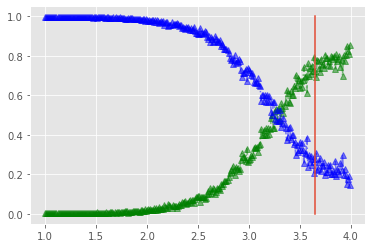

0.4982736
T 3.230000000000002



size: 64


0 : val accuracy: 0.8775747508305648 train accuracy: 0.789975
10 : val accuracy: 0.9145182724252492 train accuracy: 0.862575
20 : val accuracy: 0.9015282392026578 train accuracy: 0.91425
30 : val accuracy: 0.9024916943521595 train accuracy: 0.9159
40 : val accuracy: 0.9016279069767442 train accuracy: 0.9178
50 : val accuracy: 0.9020598006644518 train accuracy: 0.920025
60 : val accuracy: 0.9022591362126245 train accuracy: 0.921675
70 : val accuracy: 0.9025581395348837 train accuracy: 0.923025
80 : val accuracy: 0.9024916943521595 train accuracy: 0.924275
90 : val accuracy: 0.902624584717608 train accuracy: 0.9257
100 : val accuracy: 0.9026910299003322 train accuracy: 0.9265
110 : val accuracy: 0.902890365448505 train accuracy: 0.9277
120 : val accuracy: 0.9027906976744186 train accuracy: 0.928225
130 : val accuracy: 0.9028239202657807 train accuracy: 0.929525
140 : val accuracy: 0.9025581395348837 train accuracy: 0.930425
150 : val accuracy: 0.902392026578073 train accuracy: 0.93125
16

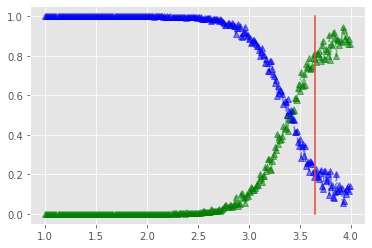

0.5011918
T 3.370000000000002



size: 128


0 : val accuracy: 0.8996013289036545 train accuracy: 0.64805
10 : val accuracy: 0.9150830564784053 train accuracy: 0.81915
20 : val accuracy: 0.9179069767441861 train accuracy: 0.89565
30 : val accuracy: 0.9260797342192691 train accuracy: 0.93435
40 : val accuracy: 0.9289036544850499 train accuracy: 0.945825
50 : val accuracy: 0.9309634551495016 train accuracy: 0.948925
60 : val accuracy: 0.9308970099667774 train accuracy: 0.95065
70 : val accuracy: 0.9302990033222591 train accuracy: 0.95295
80 : val accuracy: 0.9301993355481728 train accuracy: 0.95445
90 : val accuracy: 0.9303986710963456 train accuracy: 0.95585
100 : val accuracy: 0.9310963455149501 train accuracy: 0.95745
110 : val accuracy: 0.9315614617940199 train accuracy: 0.95875
120 : val accuracy: 0.9311627906976744 train accuracy: 0.959575
130 : val accuracy: 0.9312624584717608 train accuracy: 0.960425
140 : val accuracy: 0.9313953488372093 train accuracy: 0.96155
150 : val accuracy: 0.9315614617940199 train accuracy: 0.96192

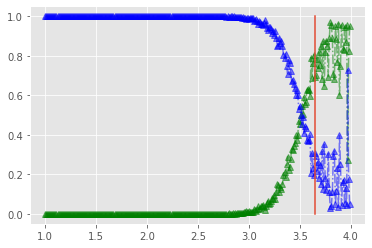

0.49990672
T 3.5100000000000025



size: 256


0 : val accuracy: 0.5572425249169435 train accuracy: 0.525475



RuntimeError: CUDA out of memory. Tried to allocate 9.77 GiB (GPU 0; 31.75 GiB total capacity; 21.55 GiB already allocated; 7.47 GiB free; 522.19 MiB cached)

In [8]:
ind = []
left = []
right = []
acc = []
size = 16
while size <= 128:
    # load
    x = np.arange(1, 3.5, 0.0625)
    X_train, y_train = load(size, "train", 40000)
    X_test, y_test = load(size, "test", 30100)
            
    print("size:", size)
    
    X_test_time = np.arange(1, 4, 0.01)
    
    X_test = np.array(X_test)
    X_test = X_test.reshape(X_test.shape[0], size*size)
    X_test = torch.from_numpy(X_test).to(device)
    y_test = np.array(y_test)
    
    X_train = np.array(X_train)
    X_train = X_train.reshape(X_train.shape[0], size*size)
    X_train = torch.from_numpy(X_train).to(device)
    y_train = torch.from_numpy(np.array(y_train)).to(device)
    train_data = TensorDataset(X_train, y_train)
    
    torch.cuda.empty_cache()
    #train
    net = Net(size*size)
    net.to(device)
    net.train()
    
    cr = torch.nn.Softmax()
    criterion = torch.nn.CrossEntropyLoss()
    lr=3*(10**-4)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=0.01)
    for e in tqdm(range(400)):
        net.train()    
        output = net.forward(X_train.float())
        loss = criterion(output, y_train.long())
        loss.backward()
        optimizer.step()
        net.zero_grad()

        if e % 10 == 0:
            net.eval()
            output = []
            output_val = []
            labels_train = []
            output = net.forward(X_train.float())
            output_val = net.forward(X_test.float())


            print(e, ":", "val accuracy:", 
                    accuracy_score(np.around(cr((output_val))[:, 1].cpu().detach().numpy()), y_test),
                    "train accuracy:", accuracy_score(np.around(cr(output)[:, 1].cpu().detach().numpy()), y_train.cpu().detach().numpy()))
    
    net.eval()
    plot_fitting()
    find_point()
    
    output_val = net.forward(X_test.to(device).float())
    acc.append(accuracy_score(np.around(cr((output_val))[:, 1].cpu().detach().numpy()), y_test))
    print("T", ind[-1])
    size *=2


In [13]:
df = pd.DataFrame()
df["Размер решетки"] = [16, 32, 64, 128]
df["Температура"] = ind
df["Точность"] = acc

In [14]:
df.head()

,Размер решетки,Температура,Точность
0,16,3.09,0.784884
1,32,3.23,0.848804
2,64,3.40,0.900033
3,128,3.51,0.932027


In [12]:
ind = np.array(ind)
left = np.array(left)
right = np.array(right)
t = 1/(np.abs(3.65 - ind)) 
l = 1/(np.abs(3.65 - left))
r = 1/(np.abs(3.65 - right))
er = np.concatenate((np.abs(t-l).reshape(left.shape[0], -1), np.abs(t-r).reshape(left.shape[0], -1)), axis=1)
er_lin = np.concatenate(((np.abs((ind)-(left))).reshape(left.shape[0], -1), np.abs((ind)-(right)).reshape(left.shape[0], -1)), axis=1)
er = er.reshape(2,-1)
er_lin = er_lin.reshape(2,-1)